In [11]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [12]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#hyper parameters for training
block_size = 8
batch_size = 4

cuda


In [13]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(len(text))

232309


In [14]:
print(text[:200])

﻿  DOROTHY AND THE WIZARD IN OZ

  BY

  L. FRANK BAUM

  AUTHOR OF THE WIZARD OF OZ, THE LAND OF OZ, OZMA OF OZ, ETC.

  ILLUSTRATED BY JOHN R. NEILL

  BOOKS OF WONDER WILLIAM MORROW & CO., INC. NEW


In [15]:
chars = sorted(set(text)) #set of all characters in the txt
print(chars)
print(len(chars))

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']
81


In [16]:
#encoder and decoder
string_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_string = {i:ch for i, ch in enumerate(chars)}

encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

encode('hello')

[61, 58, 65, 65, 68]

In [17]:
decode(encode('hello'))

'hello'

In [18]:
#loading text(wizard_of_oz) into tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])

tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,
         1, 47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26,
        49,  0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,
         0,  0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1,
        36, 25, 38, 28,  1, 39, 30,  1, 39, 50])


## Bigram model
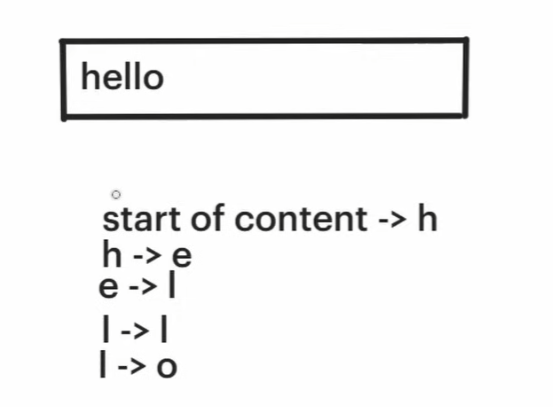

### only predicts the next character using the current character
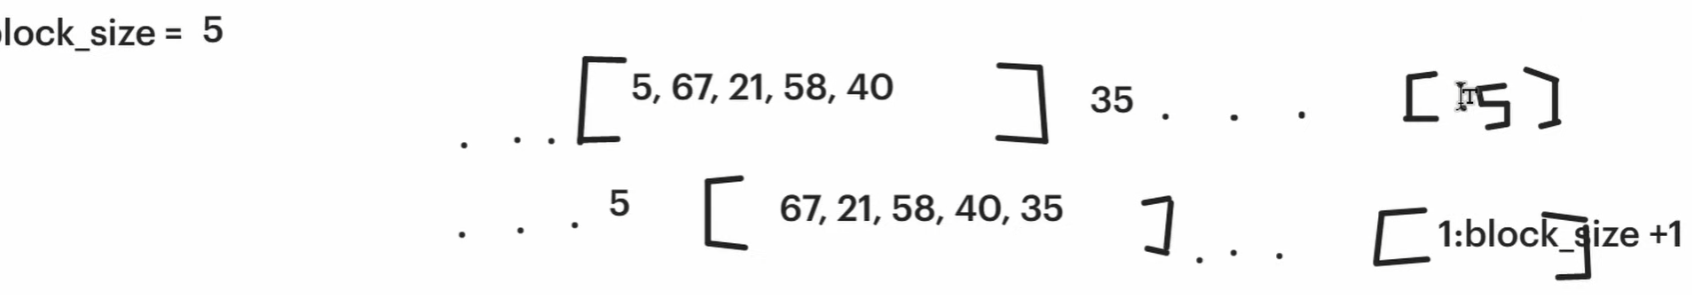

In [20]:
# splitting to training and validation sets

n= int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

# block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print('when input is', context, 'target is', target)

when input is tensor([80]) target is tensor(1)
when input is tensor([80,  1]) target is tensor(1)
when input is tensor([80,  1,  1]) target is tensor(28)
when input is tensor([80,  1,  1, 28]) target is tensor(39)
when input is tensor([80,  1,  1, 28, 39]) target is tensor(42)
when input is tensor([80,  1,  1, 28, 39, 42]) target is tensor(39)
when input is tensor([80,  1,  1, 28, 39, 42, 39]) target is tensor(44)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44]) target is tensor(32)


# horizontal window size is "block"
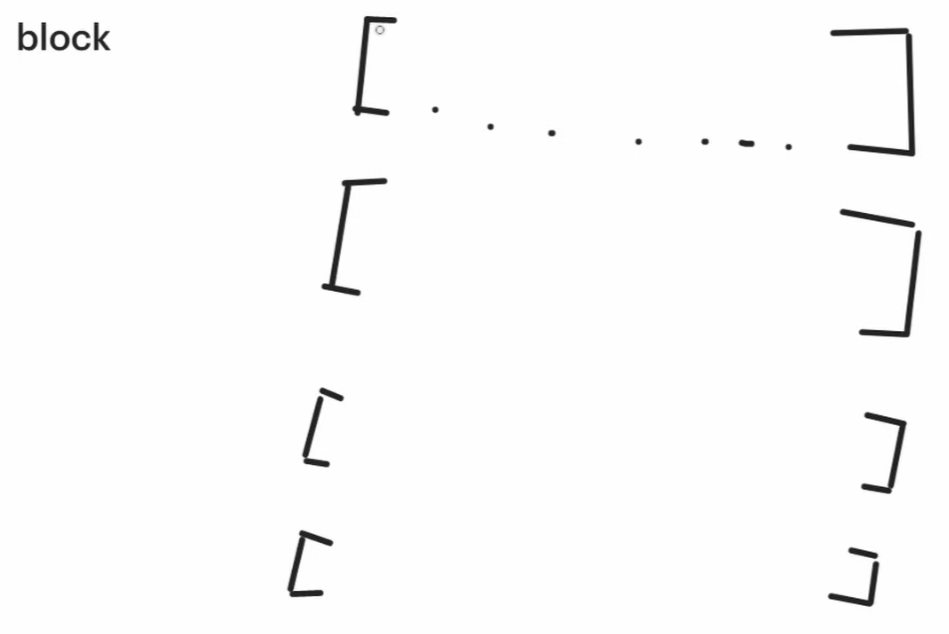

# no of blocks is "batch"

In [61]:
n= int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    #Randomly picks batch_size starting positions (indices) in the data.
    #block_size is the context length (the number of tokens the model sees at once).
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # print(ix)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

x, y = get_batch('train')
print('inputs:')
#print(x.shape)
print(x)
print('targets:')
print(y)



inputs:
tensor([[ 0, 67, 54, 66, 58,  1, 76, 54],
        [ 1, 76, 62, 65, 57, 10, 56, 54],
        [62, 72,  0, 54, 65, 76, 54, 78],
        [ 1, 73, 68, 68, 64,  1, 68, 59]], device='cuda:0')
targets:
tensor([[67, 54, 66, 58,  1, 76, 54, 72],
        [76, 62, 65, 57, 10, 56, 54, 73],
        [72,  0, 54, 65, 76, 54, 78, 72],
        [73, 68, 68, 64,  1, 68, 59, 59]], device='cuda:0')


<h3>Forward Function Explanation</h3>

<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
def forward(self, index, targets=None):
    logits = self.token_embeddings_table(index)

    if targets is None:
        loss = None
    else:
        # reshaping what logits looks like
        # batch, time, channels (vocabulary size)
        B, T, C = logits.shape
        # we are paying attention to C (vocabulary), so we do B*T as they are not that important
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
</pre>

<h4>Explanation</h4>
<ul>
  <li><b>index</b>: token IDs input to the model (shape: [batch, time])</li>
  <li><b>token_embeddings_table</b>: converts token IDs to embeddings → output shape [batch, time, vocab_size]</li>
  <li><b>logits</b>: model’s raw predictions before softmax</li>
  <li><b>targets</b>: the true next-token IDs</li>
  <li><b>loss</b>: computed only if <code>targets</code> are provided using cross-entropy</li>
</ul>

<h4>Shape Breakdown</h4>
<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
logits shape: (B, T, C)
targets shape: (B, T)
reshaped logits: (B*T, C)
reshaped targets: (B*T)
</pre>

<h4>Example</h4>
<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
index = [
 [4,  1, 12, 12, 15],   # sequence 1 (T=5)
 [0, 23, 15, 18, 12]    # sequence 2 (T=5)
]
Shape: (B, T) = (2, 5)
</pre>

<h4>After Embedding Lookup</h4>
<p>Each token ID is replaced with a vector of length <code>C</code> (the vocabulary size).</p>

<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
logits = [
  [
    [0.1, -0.5, ..., 1.2],  # token 1 in seq1 → C=65 features
    [1.1,  0.3, ..., -0.9], # token 2 in seq1
    ...
  ],
  [
    [-0.2, 0.8, ..., 0.7],  # token 1 in seq2
    ...
  ]
]
Shape: (B, T, C) = (2, 5, 65)
</pre>

<h4>📊 Meaning of Each Dimension</h4>
<table border="1" cellpadding="6" cellspacing="0" style="border-collapse:collapse; text-align:left;">
  <tr style="background-color:#eaecef;">
    <th>Dimension</th>
    <th>What It Represents</th>
    <th>Example</th>
  </tr>
  <tr>
    <td><b>B (Batch)</b></td>
    <td>Number of sequences processed in parallel</td>
    <td>2 text chunks</td>
  </tr>
  <tr>
    <td><b>T (Time)</b></td>
    <td>Number of tokens (characters/words) in each sequence</td>
    <td>5 characters per chunk</td>
  </tr>
  <tr>
    <td><b>C (Channel)</b></td>
    <td>Number of features (embedding size or vocab size) per token</td>
    <td>65 logits (one per vocabulary token)</td>
  </tr>
</table>

<h4>🧩 Why Reshape Later?</h4>
<p>When computing loss:</p>
<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
logits = logits.view(B*T, C)
targets = targets.view(B*T)
</pre>
<p>We flatten batch and time together:</p>
<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
(2, 5, 65) → (10, 65)
(2, 5) → (10)
</pre>
<p>This allows PyTorch to easily compare each token’s prediction with its true label using <code>F.cross_entropy</code>.</p>

<h4>🧠 Visual Summary</h4>
<pre style="background-color:#f6f8fa; padding:10px; border-radius:8px;">
 ┌─────────────────────────────────────────────┐
 │ logits (B, T, C)                            │
 │                                             │
 │  ┌───────────────┬───────────────┐          │
 │  │ token1 logits │ token2 logits │  ← T=5   │
 │  │ (size C=65)   │ (size C=65)   │          │
 │  ├───────────────┼───────────────┤          │
 │  │ token1 logits │ token2 logits │          │
 │  │ (size C=65)   │ (size C=65)   │          │
 │  └───────────────┴───────────────┘          │
 │   ↑                                         │
 │   B=2 examples                              │
 └─────────────────────────────────────────────┘
</pre>

<h4>Output</h4>
<ul>
  <li>If <code>targets=None</code> → returns <b>logits</b> only (used during inference)</li>
  <li>If <code>targets</code> provided → returns <b>loss</b> (used during training)</li>
</ul>


In [73]:
# initialize neural net
from torch.nn import functional as F
import torch.nn as nn


vocab_size = len(chars)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # nn.Embedding is like a lookup table
        # the embedding matrix is (vocab_size × vocab_size) — each row directly represents the logits for the next character.
        self.token_embeddings_table = nn.Embedding(vocab_size, vocab_size)
        print(self.token_embeddings_table(data))

    def forward(self, index, targets=None):
        logits = self.token_embeddings_table(index)

        if targets is None:
            loss = None
        else:
            # reshaping what logits looks like
            # batch, time, channels (vocabulary size)
            B, T, C = logits.shape
            # we are paying attention to C (vocabulary), so we do B*T as they are not that important
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.forward(index)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) #-ve index because last dimension # (B, C)
            #sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            #append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)

        return index

model = BigramLanguageModel(vocab_size)
m = model.to(device)

context = torch.zeros((1, 1), dtype = torch.long, device=device)# torch.long is equivalent to int64
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

tensor([[-1.7602, -1.4253, -0.3922,  ..., -0.0087,  1.1087,  0.6485],
        [-1.1088, -0.3180,  2.0144,  ..., -0.0482, -0.1529, -0.0433],
        [-1.1088, -0.3180,  2.0144,  ..., -0.0482, -0.1529, -0.0433],
        ...,
        [-0.3781, -0.4374,  0.9261,  ...,  0.8418,  0.6775,  0.3911],
        [-1.7574,  0.1789, -0.9297,  ...,  0.6650, -0.6036,  0.1381],
        [-0.4665,  1.1441, -0.1434,  ...,  1.2376,  0.3995, -0.6003]],
       grad_fn=<EmbeddingBackward0>)

6BP.NAxZB7BI
vpV"BwD?XJd"m!mbUC2I1GnO
f﻿pIJP8PqjZ4Se')N.jSvf56AydAGoZ8GqjZ4R﻿z8XzJwDXB
s!Z8pDZ:PUqM(F5IjZoMMh3_af-w(StO*qSN6TrH?N'!La5hB75Wxv,mf'?Q4k[C1N10vHGfVuDK8pli5NU3 NLu-pq4FCuV0"BH;3sJ'c.6SR!;3PoK.PjK_yFL;rw[CSer&8:P.a6bnq[z-9YW,u;J3TBs):!M]5QclNa6mb)c"Jeti ﻿"9SUdt-9Q;366:m5oBhuNA!sZ;JqHU-P
7-IOOd[ps:?Ced(TMM?7*[dpHsipgv&﻿:M3A!M(xDU39[C6NgHRr5FQYE&TW)"f9gcjB7PoPF2jUk1tEP7VOW58I 57Dy1ZbnFG-:5OW;
6bn(M,N5A,yXUhDRE6﻿tLQnMF0zji)0x&Aiq&WbA8IF7VJDhT*_g NAKr'&Ug7Fwn&AkTo.*ARBg9'cJU:iN9_,e9P1ofTT


In [74]:
context

tensor([[0]], device='cuda:0')

In [56]:
@torch.no_grad()
def estimate_loss():

    out = {}
    model.eval() # puts model in evaluation mode {dropout is off}

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # puts the model on training mode, weights and biases are updated during this phase {dropout is active}
    return out

In [58]:
# create PyTorch optimizer

learning_rate = 3e-4
max_iters = 10000
#eval_interval = 2500
eval_iters = 250
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #adam weight decay optimizer algo

for iter in range(max_iters):

    if iter% eval_iters == 0:
        losses = estimate_loss()
        print(f'step: {iter}, train loss: {losses['train']}, val loss: {losses['val']}')
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step: 0, train loss: 3.0856878757476807, val loss: 3.0678038597106934
step: 250, train loss: 3.0410048961639404, val loss: 3.0744240283966064
step: 500, train loss: 2.9943628311157227, val loss: 3.038813591003418
step: 750, train loss: 3.00406813621521, val loss: 3.0213735103607178
step: 1000, train loss: 2.9955358505249023, val loss: 2.9782826900482178
step: 1250, train loss: 2.9683902263641357, val loss: 3.0011706352233887
step: 1500, train loss: 2.9503254890441895, val loss: 2.9664599895477295
step: 1750, train loss: 2.9210963249206543, val loss: 2.9467997550964355
step: 2000, train loss: 2.933608055114746, val loss: 2.9372963905334473
step: 2250, train loss: 2.8957650661468506, val loss: 2.9167206287384033
step: 2500, train loss: 2.8494760990142822, val loss: 2.9020028114318848
step: 2750, train loss: 2.857297658920288, val loss: 2.8993568420410156
step: 3000, train loss: 2.8556742668151855, val loss: 2.884554862976074
step: 3250, train loss: 2.8333334922790527, val loss: 2.8538630

In [59]:
print(loss.item())

2.4900341033935547


In [47]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


Gu y I hade "
th fiech che botheantoru therome ld anciggre y owat Wig.

t can otherathe stanoro s whevele whess alilyllor th s bur hed f nd wsunhe tt ply. t ibed t b, os jo wim anelee t PYoule bicke t idie ithe was t o g gooroougefas t ired ho ombldes

ofed me tus Thers, ofly.

derdotounhig hem, tealy pe stouitupe llthing sedintimootheageve th se ed caroutanimy; wothat hare the wa y ly sthe chasorindllig h trole M cle sad thas pirt ld me fino rery llland s man. poy.
pound nd ainblllmeste fu hest


In [24]:
# loss = -ve log likelihood considering we have 80 chances -> there is a possibility of 1/80 of predicting the next token successfully

In [25]:
vocabulary = len(chars)